# Examining Wind Rotation in WRF
  
[This website](https://www-k12.atmos.washington.edu/~ovens/wrfwinds.html) has some information about rotating winds in WRF... But the formulas are different from the ones listed in UPP. I'm not sure which one I should trust.
  
shawn.s.murdzek@noaa.gov

In [47]:
import numpy as np
import xarray as xr
import netCDF4 as nc
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Only adb_graphics environment on Jet has wrf-python
try:
    import wrf
except ImportError:
    print('cannot load WRF-python module')
    
import pyDA_utils.plot_model_data as pmd

In [45]:
"""
Sample WRF and UPP Data to Examine (from Nature Run)
"""

data_path = '/mnt/lfs4/BMC/wrfruc/murdzek/sample_NR_output/'

wrf_fname = data_path + '2022043012_restart/wrfinput_d01_0000'
upp_fname = data_path + '2022043011_UPP/wrfnat_202204301200.grib2'

In [12]:
"""
Open WRF File
"""

ds_wrf = xr.open_dataset(wrf_fnme)

In [23]:
"""
List All Fields in WRF File
"""

for key in list(ds_wrf.keys()):
    try:
        print('{k}: {n}'.format(k=key, n=ds_wrf[key].attrs['description']))
    except KeyError:
        continue

LU_INDEX: LAND USE CATEGORY
ZNU: eta values on half (mass) levels
ZNW: eta values on full (w) levels
ZS: DEPTHS OF CENTERS OF SOIL LAYERS
DZS: THICKNESSES OF SOIL LAYERS
VAR_SSO: variance of subgrid-scale orography
BATHYMETRY_FLAG: Flag for bathymetry in the global attributes for metgrid data
U: x-wind component
V: y-wind component
W: z-wind component
PH: perturbation geopotential
PHB: base-state geopotential
T: perturbation potential temperature theta-t0
THM: either 1) pert moist pot temp=(1+Rv/Rd Qv)*(theta)-T0, or 2) pert dry pot temp=t
HFX_FORCE: SCM ideal surface sensible heat flux
LH_FORCE: SCM ideal surface latent heat flux
TSK_FORCE: SCM ideal surface skin temperature
HFX_FORCE_TEND: SCM ideal surface sensible heat flux tendency
LH_FORCE_TEND: SCM ideal surface latent heat flux tendency
TSK_FORCE_TEND: SCM ideal surface skin temperature tendency
MU: perturbation dry air mass in column
MUB: base state dry air mass in column
NEST_POS: -
P: perturbation pressure
PB: BASE STATE PRE

In [7]:
"""
Open UPP File
"""

ds_upp = xr.open_dataset(upp_fname, engine='pynio')

In [8]:
"""
List All Fields in UPP File
"""

for key in list(ds_upp.keys()):
    print('{k}: {n}'.format(k=key, n=ds_upp[key].attrs['long_name']))

TMP_P0_L1_GLC0: Temperature
TMP_P0_L103_GLC0: Temperature
TMP_P0_L105_GLC0: Temperature
POT_P0_L103_GLC0: Potential temperature
DPT_P0_L103_GLC0: Dew point temperature
LHTFL_P0_L1_GLC0: Latent heat net flux
SHTFL_P0_L1_GLC0: Sensible heat net flux
SPFH_P0_L103_GLC0: Specific humidity
SPFH_P0_L105_GLC0: Specific humidity
RH_P0_L4_GLC0: Relative humidity
RH_P0_L103_GLC0: Relative humidity
RH_P0_L204_GLC0: Relative humidity
PWAT_P0_L200_GLC0: Precipitable water
PRATE_P0_L1_GLC0: Precipitation rate
SNOD_P0_L1_GLC0: Snow depth
WEASD_P0_L1_GLC0: Water equivalent of accumulated snow depth
CLWMR_P0_L105_GLC0: Cloud mixing ratio
ICMR_P0_L105_GLC0: Ice water mixing ratio
RWMR_P0_L105_GLC0: Rain mixing ratio
SNMR_P0_L105_GLC0: Snow mixing ratio
GRLE_P0_L105_GLC0: Graupel
CRAIN_P0_L1_GLC0: Categorical rain
CFRZR_P0_L1_GLC0: Categorical freezing rain
CICEP_P0_L1_GLC0: Categorical ice pellets
CSNOW_P0_L1_GLC0: Categorical snow
CPOFP_P0_L1_GLC0: Percent frozen precipitation
SNOWC_P0_L1_GLC0: Snow cov

In [34]:
"""
Only Retain UPP Output in Same Domain as WRF Output
"""

xmin = 0
xmax = 135
ymin = 0
ymax = 64

ds_upp_subset = ds_upp.sel(xgrid_0=slice(xmin, xmax), ygrid_0=slice(ymin, ymax))

In [38]:
"""
Rotate Winds in UPP File Using gridrot_0
"""

print()
print('gridrot_0 metadata')
for key in ds_upp_subset['gridrot_0'].attrs:
    print('{k}: {v}'.format(k=key, v=ds_upp_subset['gridrot_0'].attrs[key]))
print()

U10_grid_upp = ds_upp_subset['UGRD_P0_L103_GLC0'][0, :, :].values
V10_grid_upp = ds_upp_subset['VGRD_P0_L103_GLC0'][0, :, :].values

gridrot = ds_upp_subset['gridrot_0'].values
U10_earth_upp = (np.sin(gridrot)*V10_grid_upp +
                 np.cos(gridrot)*U10_grid_upp)
V10_earth_upp = (np.cos(gridrot)*V10_grid_upp -
                 np.sin(gridrot)*U10_grid_upp)


gridrot_0 metadata
long_name: vector rotation angle
GridType: Lambert Conformal (secant, tangent, conical or bipolar)
units: radians
formula_u: Uearth = sin(rot)*Vgrid + cos(rot)*Ugrid
formula_v: Vearth = cos(rot)*Vgrid - sin(rot)*Ugrid
note1: u and v components of vector quantities are resolved relative to grid
note2: apply formulas to derive u and v components relative to earth



In [56]:
"""
Retrieve Grid-Relative and Earth-Relative Winds from WRF
"""

nc_ptr = nc.Dataset(wrf_fname)
U10_earth_wrf, V10_earth_wrf = wrf.getvar(nc_ptr, 'uvmet10', units='m s-1')

U10_grid_wrf = np.squeeze(ds_wrf['U10'].values)
V10_grid_wrf = np.squeeze(ds_wrf['V10'].values)

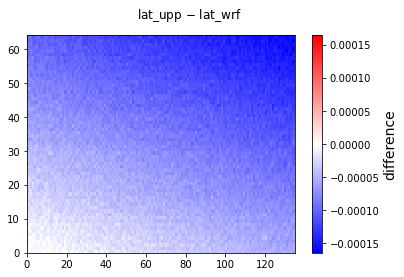

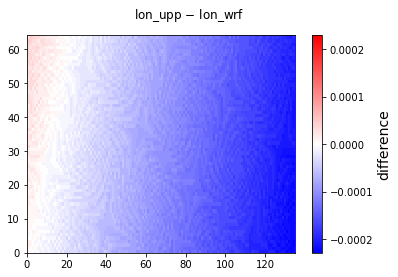

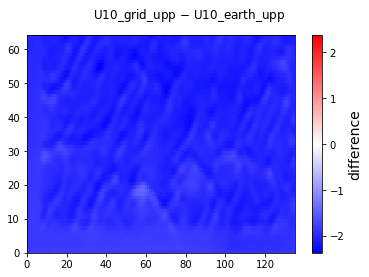

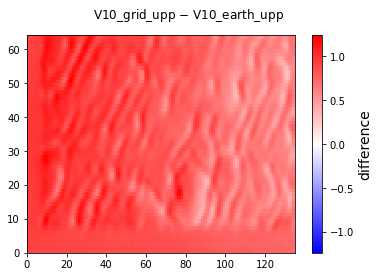

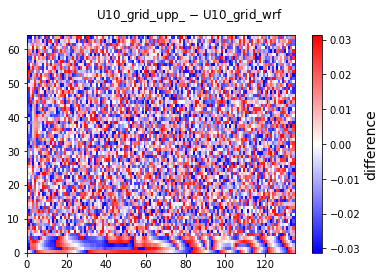

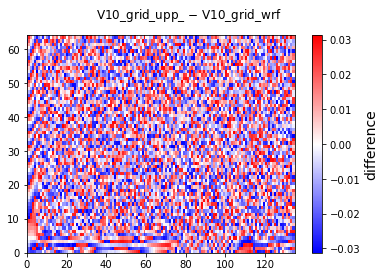

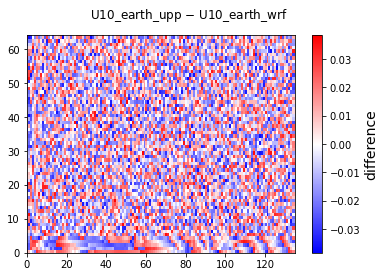

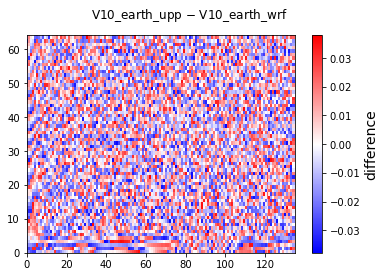

In [59]:
"""
Make Difference Plots
"""

array1 = {'lat_upp':ds_upp_subset['gridlat_0'].values,
          'lon_upp':ds_upp_subset['gridlon_0'].values,
          'U10_grid_upp':U10_grid_upp,
          'V10_grid_upp':V10_grid_upp,
          'U10_grid_upp_':U10_grid_upp,
          'V10_grid_upp_':V10_grid_upp,
          'U10_earth_upp':U10_earth_upp,
          'V10_earth_upp':V10_earth_upp}
array2 = {'lat_wrf':np.squeeze(ds_wrf['XLAT'].values),
          'lon_wrf':np.squeeze(ds_wrf['XLONG'].values),
          'U10_earth_upp':U10_earth_upp,
          'V10_earth_upp':V10_earth_upp,
          'U10_grid_wrf':U10_grid_wrf,
          'V10_grid_wrf':V10_grid_wrf,
          'U10_earth_wrf':U10_earth_wrf,
          'V10_earth_wrf':V10_earth_wrf}

###

for key1, key2 in zip(array1.keys(), array2.keys()):
    diff = array1[key1] - array2[key2]
    maxdiff = np.amax(np.abs(diff))
    fig = plt.figure()
    cax = plt.pcolormesh(diff, cmap='bwr', vmin=-maxdiff, vmax=maxdiff)
    cbar = plt.colorbar(cax)
    cbar.set_label('difference', size=14)
    plt.suptitle('{k1} $-$ {k2}'.format(k1=key1, k2=key2))
    plt.show()